In [1]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1


In [2]:
import pandas as pd
idx = pd.IndexSlice

import datetime as dt
from datetime import date
from datetime import timedelta
import dateutil.parser as dup

%aimport trans.data
%aimport trans.gtrans
%aimport trans.reg
%aimport trans.regpipe
%aimport trans.qfactors

from trans.data import GetData
gd = GetData()
from trans.gtrans import *
from trans.reg import Reg, RegAttr
from trans.regpipe import RegPipe

import trans.qfactors as qf
from trans.date_manip import Date_Manipulator

In [3]:
start = dup.parse("01/01/2015")
#end =   dup.parse("03/15/2018")

today = dt.datetime.combine( date.today(), dt.time.min)
# today = dup.parse( dt.datetime.today().strftime("%m/%d/%Y"))
end = today
start, end

refreshData = False

(datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2018, 3, 28, 0, 0))

In [4]:
existing_tickers = gd.existing()
len(existing_tickers)

1118

In [5]:
existing_tickers.sort()
changed_tickers = []
if refreshData:
    changed_tickers = gd.get_data( existing_tickers, start, end)
    cleaned = gd.clean_data(existing_tickers)

In [6]:
universe = gd.get_r1000_tickers()
len(universe)

missing_universe = list(set(universe) - set(existing_tickers))
missing_universe.sort()
print("No data for following R1000 names: {}".format(", ".join(missing_universe)))

universe = list(set(universe) - set(missing_universe))
universe.sort()
print("Available universe has {} tickers".format(len(universe)))

mom = qf.MomentumPipe(universe)
price_df = mom.load_prices( start, end)

987

No data for following R1000 names: ALR, AMSG, AWH, BCR, BEAV, BF.A, BF.B, BHI, BKFS, BRCD, CAA, CAB, CCP, COH, CPGX, CSAL, CSC, CST, DD, DOW, EMC, ENH, EQY, FEIC, FNFG, GAS, HAR, HOT, IHS, IM, IMS, ITC, JW.A, KATE, LGF, LLTC, LNKD, LVLT, LXK, MDVN, MFS, MJN, MRD, N, NRF, NSAM, PNRA, PNY, PPS, Q, RAI, RAX, RICE, SCTY, SPLS, SSS, STJ, STR, TCB, TE, TSO, TYC, UA.C, VAL, VNTV, VWR, WFM, WOOF, WWAV, YHOO
Available universe has 917 tickers


In [7]:
price_df.shape

(815, 5508)

In [8]:
dm = Date_Manipulator( mom.price_df.index )
eom_in_idx = dm.periodic_in_idx_end_of_month(end)
mom.set_endDates( eom_in_idx )

End 2018-03-28 00:00:00, last 2018-03-31 00:00:00


In [9]:
price_attr = "Adj Close"
ret_attr = "Ret"
daily_ret_df = mom.create_dailyReturns(price_attr, ret_attr )

## 12m1m: 11 month return beginning 12m ago and ending 1m ago
- so 11 month return, shift forward 1 mo

In [10]:
period_ret_attr = ret_attr + " yearly"
yearly_ret_df = mom.create_periodReturns(price_attr, period_ret_attr, periods=11)

yearly_ret_df = mom.period_ret_df
shifted_yearly_ret_df = ShiftTransformer(1).fit_transform(yearly_ret_df)
mom.period_ret_df = shifted_yearly_ret_df

In [11]:

yearly_ret_df.loc["2017-12-01":"2018-03-20", idx[ period_ret_attr, "NFLX"]]
shifted_yearly_ret_df.loc["2017-12-01":"2018-03-20", idx[ period_ret_attr, "NFLX"]]

Dt
2017-12-29    0.364224
2018-01-31    0.901780
2018-02-28    0.971315
Freq: BM, Name: (Ret yearly, NFLX), dtype: float64

Dt
2017-12-29    0.515186
2018-01-31    0.364224
2018-02-28    0.901780
Freq: BM, Name: (Ret yearly, NFLX), dtype: float64

In [12]:
daily_rank_df = mom.create_ranks()

In [13]:
factor_ret_attr = ret_attr + " Factor"
factor_df = mom.create_factor()

In [29]:
f_ret = factor_df.loc[:, idx["Ret", "Port net"]]
f_ret.loc["2018-01-23":]

Dt
2018-01-23    0.000060
2018-01-24    0.000549
2018-01-25    0.008073
2018-01-26    0.008339
2018-01-29   -0.002029
2018-01-30    0.009761
2018-01-31    0.003208
2018-02-01   -0.000456
2018-02-02    0.003843
2018-02-05   -0.001362
2018-02-06    0.000603
2018-02-07    0.005139
2018-02-08   -0.008440
2018-02-09    0.009649
2018-02-12    0.003693
2018-02-13    0.009485
2018-02-14   -0.003262
2018-02-15    0.001089
2018-02-16   -0.005105
2018-02-20    0.004916
2018-02-21    0.008509
2018-02-22   -0.002444
2018-02-23   -0.003442
2018-02-26    0.000891
2018-02-27    0.002227
2018-02-28    0.008274
2018-03-01   -0.006584
2018-03-02   -0.004009
2018-03-05   -0.007916
2018-03-06    0.004542
2018-03-07    0.007474
2018-03-08    0.002333
2018-03-09    0.008626
2018-03-12   -0.005707
2018-03-13   -0.001778
2018-03-14    0.002559
2018-03-15    0.005930
2018-03-16   -0.007541
2018-03-19    0.004904
2018-03-20    0.016063
2018-03-21   -0.007176
2018-03-22   -0.009638
2018-03-23   -0.005407
2018-03-

## Standard deviation computed over last year

In [37]:
std_dev = f_ret.loc[end - dt.timedelta(days=365) :].std()

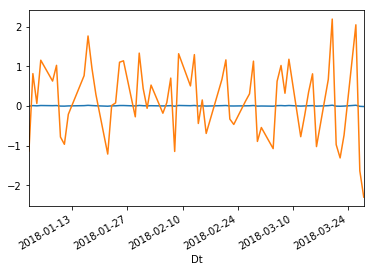

In [40]:
%matplotlib inline
f_ret_recent = f_ret.loc["2018-01-01":]
f_ret_recent.plot()
f_ret_recent_z = f_ret_recent/std_dev

f_ret_recent_z.plot()

In [42]:
gd.save_data(factor_df, "mom_r1000_12m1m.pkl")

In [43]:
factor_df.to_csv("mom_r1000_12m1m.csv")

In [44]:
f_ret_recent_z.tail()

Dt
2018-03-22   -1.312744
2018-03-23   -0.736394
2018-03-26    2.043409
2018-03-27   -1.639273
2018-03-28   -2.300742
Name: (Ret, Port net), dtype: float64